In [1]:
# Import data handling libraries
import pandas as pd
import numpy as np

#plot the distribution of GRAD_SEM
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#read in the raw dataset
df = pd.read_csv('data_set_10_17.csv')

#a simple function to get info about the dataset
def gradestats(df):
    total = df["STUDENT"].nunique()
    grads = df.groupby("STUDENT")["DEG_CD"].apply(lambda x: x.notnull().any()).sum()
    percent = np.round(grads/total*100,2)
    print('Rows:', len(df))
    print('Total:', total)
    print('Grads:', grads)
    print('Percent:', percent)
    print()

gradestats(df)

Rows: 30394
Total: 13065
Grads: 7622
Percent: 58.34



In [3]:
#remove students who entered before 2008 (because the data is shaky)
df = df[df['ENTRY_CCYY'] >= 2008]

print('After removing students who entered before 2008:')
gradestats(df)

After removing students who entered before 2008:
Rows: 30219
Total: 13013
Grads: 7578
Percent: 58.23



In [4]:
#dropped degrees are graduate degrees. kept degrees are undergraduate degrees.
dropped_degrees = ['MRE', 'MCP', 'MED', 'MFA', 'MTR', 'MHC', 'MFS', 'MHO', 'MAA', 'DVM', 'MBS', 'MBA', 'MA', 'MEN', 'MFN', 'MAT', 'PHD', 'MS']

#get a list of all students who got a graduate degree
grad_students = df[df['DEG_CD'].isin(dropped_degrees)]['STUDENT'].unique()

#drop the above students
df = df[~df['STUDENT'].isin(grad_students)]

# #here I drop the graduate degrees
# for x in dropped_degrees:
#     df = df.drop(df[df['DEG_CD'] == x].index)
# df.reset_index(drop=True, inplace=True)

# print('After dropping graduate degrees')
# gradestats(df)

print('After dropping students who took classes towards a graduate degree')
gradestats(df)

After dropping students who took classes towards a graduate degree
Rows: 27710
Total: 12685
Grads: 7250
Percent: 57.15



In [5]:
#Next, we format the semester in which the student entered the university, took the course, and obtained a degree

#subtract 2008 from 'ENTRY_CCYY', 'SEM_CCYY', and 'SEM_CCYY.1'
for x in ['ENTRY_CCYY', 'SEM_CCYY', 'SEM_CCYY.1']:
    df[x] = df[x] - 2000

#encode df['ENTRY_SEM_CD] as {'F':0.6,'S':0.2,1:0.4}
df['ENTRY_SEM_CD'] = df['ENTRY_SEM_CD'].replace({'F':0.6,
                                                 'S':0.0,
                                                 '1':0.4})

#Next, we encode the semester in which the course was taken and the semester in which the student graduated
for sem in ['SEM_CD', 'SEM_CD.1']:
    df[sem] = df[sem].replace({'F': 1.0, 
                               '1': 0.6, 
                               'S': 0.4})

#create columns for entry, course, and grad semesters.
df['ENT_SEM'] = df['ENTRY_CCYY'] + df['ENTRY_SEM_CD']
df['CRSE_SEM'] = df['SEM_CCYY'] + df['SEM_CD']
df['GRAD_SEM'] = df['SEM_CCYY.1'] + df['SEM_CD.1']

#Remove students who enrolled at least in Summer 2020 and did not graduate.
df = df.drop(df[(df['ENT_SEM'] >= 20.4) & (df['GRAD_SEM'].isnull())].index)

print('After removing students who enrolled later than Spring 2020 and did not yet graduate:')
gradestats(df)

#drop all rows for which CRSE_SEM is greater than 8 or greater than GRAD_SEM (if this occurs, it means that the student took the course after they graduated; this scenario likely happened because the student continued taking courses for a second degree)
df = df[(df['GRAD_SEM'].isnull()) | (df['CRSE_SEM'] <= df['GRAD_SEM'])]

print('After removing courses taken after graduation:')
gradestats(df)

#subtract ENT_SEM from CRSE_SEM and GRAD_SEM to get relative semester values
df['CRSE_SEM'] = df['CRSE_SEM'] - df['ENT_SEM']
df['GRAD_SEM'] = df['GRAD_SEM'] - df['ENT_SEM']

print(df['CRSE_SEM'].describe())
print(df['GRAD_SEM'].describe())

#remove entries corresponding to courses taken after 9.5 semesters
df = df[df['CRSE_SEM'] <= 3.8]

print('After dropping students who took a course after 8 full semesters:')
gradestats(df)

After removing students who enrolled later than Spring 2020 and did not yet graduate:


/var/folders/br/143tjw8148nftd61z3w9qzv40000gp/T/ipykernel_10163/2150409325.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ENTRY_SEM_CD'] = df['ENTRY_SEM_CD'].replace({'F':0.6,
/var/folders/br/143tjw8148nftd61z3w9qzv40000gp/T/ipykernel_10163/2150409325.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[sem] = df[sem].replace({'F': 1.0,


Rows: 22058
Total: 9480
Grads: 7250
Percent: 76.48

After removing courses taken after graduation:
Rows: 21915
Total: 9454
Grads: 7224
Percent: 76.41

count    21915.000000
mean         1.699366
std          1.364657
min          0.200000
25%          0.800000
50%          1.400000
75%          2.400000
max         12.800000
Name: CRSE_SEM, dtype: float64
count    18314.000000
mean         4.007120
std          1.081257
min          0.800000
25%          3.800000
50%          3.800000
75%          4.400000
max         13.800000
Name: GRAD_SEM, dtype: float64
After dropping students who took a course after 8 full semesters:
Rows: 20562
Total: 9102
Grads: 6922
Percent: 76.05



In [6]:
check = df[['STUDENT',
                'CRSE',
                'SEM_CCYY',
                'SEM_CD'
                ]]
#check how many duplicate rows are there in the dataset
check.duplicated().sum()

np.int64(1160)

In [7]:
"""Output: np.int64(1315)"""

#get the indices of the duplicate rows and drop them from the 'df' dataset
df.drop(index= check[check.duplicated()].index, inplace=True)

print('After dropping duplicates:')
gradestats(df)

After dropping duplicates:
Rows: 19402
Total: 9102
Grads: 6922
Percent: 76.05



In [8]:
#remove the 'X' and 'H' appearing in any CRSE name
df['CRSE'] = df['CRSE'].str.replace('X', '')
df['CRSE'] = df['CRSE'].str.replace('H', '')

#remove all courses for which CRSE_TITLE contains 'EDUC'
df = df[~df['CRSE_TITLE'].str.contains('EDUC')]

#the courses x = '302' and '403' both refer to abstract algebra II, so let's combine them and call them '302'
#these are supposed to be the same, so re-number the '403' to '302'
df['CRSE'] = df['CRSE'].replace('403', '302')

#the courses x = '142' and '145' are both variations of trig, so let's combine them and call them '142'
df['CRSE'] = df['CRSE'].replace('145', '142')

#the course x='407' is applied linear algebra; very similar to '317', so let's combine them and call them '317'
df['CRSE'] = df['CRSE'].replace('407', '317')

#the courses x='497' and '397' are both about teaching secondary school math, we combine them and call them '397'
df['CRSE'] = df['CRSE'].replace('497', '397')

#it's natural to combine x = '490' (Independent Study) with x='495' (Special topics) and call them '495'
df['CRSE'] = df['CRSE'].replace('490', '495')

#combine '106' (Discovering math) with '105' (Intro to math ideas) and call them '105'
df['CRSE'] = df['CRSE'].replace('106', '105')

#drop '181' (Life sci calc & MDL 1) because it is no longer offered
df = df.drop(df[df['CRSE'] == '181'].index)

#cast the course numbers as integers
df['CRSE'] = df['CRSE'].astype(int)

#replace all courses >= 500 with 500 (grad courses)
df['CRSE'] = np.where(df['CRSE'] >= 500, 500, df['CRSE'])

#for any row with CRSE = 500, replace the CRSE_TITLE with 'GRADUATE MATH'
df['CRSE_TITLE'] = np.where(df['CRSE'] == 500, 'GRADUATE MATH', df['CRSE_TITLE'])

#if any CRSE corresponds to more than one CRSE_TITLE, then replace all CRSE_TITLES with the first one that appears
df['CRSE_TITLE'] = df.groupby('CRSE')['CRSE_TITLE'].transform('first')

#if any CRSE_TITLE corresponds to more than one CRSE, then replace all CRSEs with the first one that appears
df['CRSE'] = df.groupby('CRSE_TITLE')['CRSE'].transform('first')

#remove courses with less than 50 students
df = df.groupby('CRSE').filter(lambda x: len(x) >= 50)

print('After formatting courses, and removing courses with low enrollment:')
gradestats(df)

After formatting courses, and removing courses with low enrollment:
Rows: 19036
Total: 8994
Grads: 6832
Percent: 75.96



In [9]:
crse_counts = df.groupby(by=['CRSE','CRSE_TITLE']).size().reset_index(name='COUNT').sort_values(by='COUNT', ascending=False).reset_index(drop=True)
crse_counts.to_csv('crse_counts.csv', index=False)
crse_counts

,CRSE,CRSE_TITLE,COUNT
0,165,CALCULUS I,2605
1,166,CALCULUS II,2165
2,265,CALCULUS III,1550
3,143,PREP FOR CALCULUS,1445
4,140,COLLEGE ALGEBRA,1276
5,104,INTRO TO PROBABILTY,1162
6,150,DISC MATH BUS&SOC S,1048
7,207,MATRCES&LINEAR ALGB,844
8,201,INTRO TO PROOFS,671
9,317,THRY LINEAR ALGEBRA,630


In [10]:
crse_counts.sort_values(by='CRSE',inplace=True)

#make a dict of CRSE : CRSE_TITLE pairs
crse_counts['CRSE'] = crse_counts['CRSE'].astype(str)
courses = crse_counts['CRSE'].unique().tolist()
crse_dict = dict(zip(crse_counts['CRSE'], crse_counts['CRSE_TITLE']))
crse_dict

{'25': 'HIGH SCHOOL ALGEBRA',
 '101': 'ORIENTATION IN MATH',
 '104': 'INTRO TO PROBABILTY',
 '105': 'INTRO TO MATH IDEAS',
 '140': 'COLLEGE ALGEBRA',
 '142': 'TRIG&ANALY GEOMETRY',
 '143': 'PREP FOR CALCULUS',
 '150': 'DISC MATH BUS&SOC S',
 '151': 'BUS & SOC SCI CALC',
 '160': 'SURVEY OF CALCULUS',
 '165': 'CALCULUS I',
 '166': 'CALCULUS II',
 '201': 'INTRO TO PROOFS',
 '207': 'MATRCES&LINEAR ALGB',
 '240': 'INVESTM&CREDIT MATH',
 '265': 'CALCULUS III',
 '266': 'ELEM DIFF EQUATNS',
 '267': 'DIFF EQ & TRANSFMS',
 '301': 'ABSTRACT ALGEBRA I',
 '302': 'ABSTRCT ALGEBRA II',
 '304': 'COMBINATORICS',
 '314': 'GRAPH THEORY',
 '317': 'THRY LINEAR ALGEBRA',
 '341': 'INTR THY PROBAB&S I',
 '342': 'INTR THY PR&STAT II',
 '350': 'NUMBER THEORY',
 '365': 'COMPLEX VARIABLES',
 '373': 'INTR SCIENTF CMPTNG',
 '385': 'INTR PART DIFF EQUA',
 '397': 'TEACH SEC SCHL MATH',
 '414': 'ANALYSIS I',
 '415': 'ANALYSIS II',
 '435': 'GEOMETRY I',
 '436': 'GEOMETRY II',
 '492': 'UNDERGRAD SEMINAR',
 '495': 'INDEP

In [11]:
#format the grades
df['GRADE_CATGORY'] = df['GRADE_CATGORY'].map({'C- OR BELOW':-1,
                                               'ABOVE C-':1,
                                               'Satisfactory/Pass':1})

df['CRSE'] = df['CRSE'].astype(str)
#We add one column for each course and temporarily stick a 0 in each column
for x in courses:
    df[x] = 0.0

# #rpelace grad_time with 3.8/grad_time. This is because the longer it takes to graduate, the less likely the student is to graduate. This also introduces an element of continuity in the values when we fill in the nan values (non-graduates) with 0.
# df['GRAD_SEM'] = 3.8/df['GRAD_SEM']
# df['GRAD_SEM'].fillna(0, inplace=True)

#Now, in each row, if a student has taken a course x, then the value in the column 'x' is replaced with the product of the 'GRADE_CATEGORY' and 'CRSE_SEM' 
for x in courses:
    df.loc[df['CRSE'] == x, x] = df['GRADE_CATGORY'] * df['CRSE_SEM']

In [12]:
cols = df.columns.tolist()
cols

['STUDENT',
 'MAJOR_CURR',
 'MAJOR_COLL',
 'CLSFN_YR',
 'ENTRY_SEM_CD',
 'ENTRY_CCYY',
 'LEVEL',
 'SEM_CCYY',
 'SEM_CD',
 'OFFER_DEPT_ABRVN',
 'CRSE',
 'SECT',
 'GRADE_CATGORY',
 'CRSE_TITLE',
 'SEM_CCYY.1',
 'SEM_CD.1',
 'DEG_CD',
 'DEG_DATEDB',
 'MAJOR_CURR.1',
 'DEG_DESCR',
 'LAST_RGST_TERM',
 'CLSFN_YR.1',
 'MAJOR_CURR.2',
 'MAJOR_COLL.1',
 'Workday Enrolled in Fall 2024',
 'Workday Enrolled in Fall 2024 Class Standing',
 'Workday Enrolled in Fall 2024 Primary Program of Study',
 'ENT_SEM',
 'CRSE_SEM',
 'GRAD_SEM',
 '25',
 '101',
 '104',
 '105',
 '140',
 '142',
 '143',
 '150',
 '151',
 '160',
 '165',
 '166',
 '201',
 '207',
 '240',
 '265',
 '266',
 '267',
 '301',
 '302',
 '304',
 '314',
 '317',
 '341',
 '342',
 '350',
 '365',
 '373',
 '385',
 '397',
 '414',
 '415',
 '435',
 '436',
 '492',
 '495',
 '500']

In [13]:
courses = cols[cols.index('GRAD_SEM')+1:]
courses

['25',
 '101',
 '104',
 '105',
 '140',
 '142',
 '143',
 '150',
 '151',
 '160',
 '165',
 '166',
 '201',
 '207',
 '240',
 '265',
 '266',
 '267',
 '301',
 '302',
 '304',
 '314',
 '317',
 '341',
 '342',
 '350',
 '365',
 '373',
 '385',
 '397',
 '414',
 '415',
 '435',
 '436',
 '492',
 '495',
 '500']

In [14]:
final_cols = ['STUDENT','ENT_SEM','GRAD_SEM'] + courses
df = df[final_cols]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19036 entries, 0 to 30393
Data columns (total 40 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   STUDENT   19036 non-null  int64  
 1   ENT_SEM   19036 non-null  float64
 2   GRAD_SEM  15611 non-null  float64
 3   25        19036 non-null  float64
 4   101       19036 non-null  float64
 5   104       19036 non-null  float64
 6   105       19036 non-null  float64
 7   140       19036 non-null  float64
 8   142       19036 non-null  float64
 9   143       19036 non-null  float64
 10  150       19036 non-null  float64
 11  151       19036 non-null  float64
 12  160       19036 non-null  float64
 13  165       19036 non-null  float64
 14  166       19036 non-null  float64
 15  201       19036 non-null  float64
 16  207       19036 non-null  float64
 17  240       19036 non-null  float64
 18  265       19036 non-null  float64
 19  266       19036 non-null  float64
 20  267       19036 non-null  float64

In [15]:
#replace all null values with 0
df = df.fillna(0)

#group by student, choose the max value in each column
df = df.groupby('STUDENT').agg(lambda x: x.loc[x.abs().idxmax()])

#Add a column 'y' whose value is 0 if 'GRAD_SEM' is 0 or greater than 8, and 1 otherwise
df['Y'] = 0
df['Y'][(df['GRAD_SEM'] > 0) & (df['GRAD_SEM'] <= 3.8)] = 1

print('After aggregating the dataset by student and adding the target variable:')
df

After aggregating the dataset by student and adding the target variable:


/var/folders/br/143tjw8148nftd61z3w9qzv40000gp/T/ipykernel_10163/93202105.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Y'][(df['GRAD_SEM'] > 0) & (df['GRAD_SEM'] <= 3.8)] = 1
/var/folders/br/143tjw8148nftd61z3w9qzv40000gp/T/ipyker

,ENT_SEM,GRAD_SEM,25,101,104,105,140,142,143,150,...,385,397,414,415,435,436,492,495,500,Y
STUDENT,,,,,,,,,,,,,,,,,,,,,
0,20.6,3.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,19.6,3.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,19.6,3.4,0.0,0.0,1.8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,16.6,3.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10,18.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13060,14.6,4.8,0.0,0.0,0.0,0.0,-0.4,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
13061,16.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
13062,13.6,2.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [16]:
df['165'].value_counts()

165
 0.0    6584
 0.4     739
 0.8     355
 0.4     308
 0.8     134
        ... 
-2.2       1
 2.2       1
 1.2       1
-0.2       1
 3.6       1
Name: count, Length: 73, dtype: int64

In [17]:
#scale all course columns by 2.5 (so fall and spring count as 1 sem, and summer counts as 0.5)
df[courses] = df[courses].apply(lambda x: np.round(x*2.5,1))

In [18]:
df['165'].value_counts()

165
 0.0    6584
 1.0    1047
 2.0     563
-1.0     136
-2.0     115
 4.5      86
 3.5      79
 2.5      72
-3.5      35
 5.0      33
 6.0      29
 0.5      25
 7.0      25
-4.5      23
 1.5      22
 7.5      19
 9.5      16
-2.5      12
 8.5      11
-7.0       9
 4.0       8
-5.0       7
-6.0       6
-8.5       6
-1.5       5
-3.0       3
-0.5       3
-7.5       3
 3.0       2
-9.5       2
 5.5       2
 6.5       2
-5.5       1
-4.0       1
-8.0       1
 9.0       1
Name: count, dtype: int64

In [19]:
#check the current status of the dataset
print('Rows:', len(df))
print('Grad rate:', np.round(df['Y'].mean()*100,2))

Rows: 8994
Grad rate: 51.65


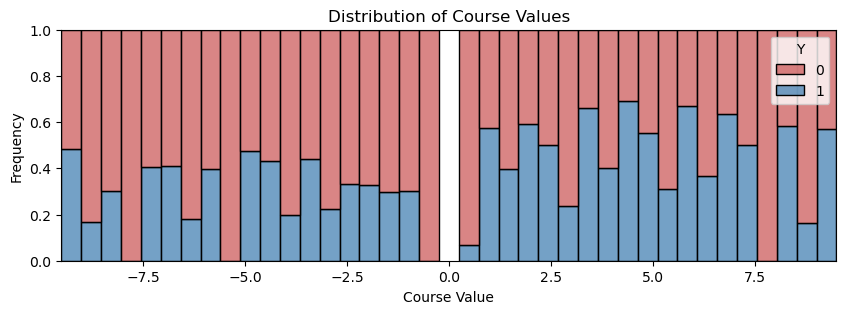

In [20]:
palette = {0: 'indianred', 1: 'steelblue'}
#get a list of all possible values in df[courses]
crse_values = [df[x].unique().tolist() for x in courses]

#flatten the list
crse_values = [item for sublist in crse_values for item in sublist]
crse_values = list(set(crse_values))
crse_values.sort()

# Reshape the DataFrame for plotting
melted_df = pd.melt(df, id_vars=['Y'], value_vars=courses, var_name='Course', value_name='Value')
melted_df_nonzero = melted_df[melted_df['Value'] != 0]

#plot a histogram of how often each value in crse_values appears in df[courses]
fig, ax = plt.subplots(figsize=(10,3))
sns.histplot(data=melted_df_nonzero,
             x='Value',
             hue='Y',
             multiple='fill',
             palette=palette,
             bins=len(crse_values),
             ax=ax)
plt.xlabel('Course Value')
# plt.yscale('log')
plt.ylabel('Frequency')
plt.title('Distribution of Course Values')
plt.show()

In [21]:
crse_dict = \
{'25': 'HIGH SCHOOL ALGEBRA',
 '101': 'ORIENTATION IN MATH',
 '104': 'INTRO TO PROBABILTY',
 '105': 'INTRO TO MATH IDEAS',
 '140': 'COLLEGE ALGEBRA',
 '142': 'TRIG&ANALY GEOMETRY',
 '143': 'PREP FOR CALCULUS',
 '150': 'DISC MATH BUS&SOC S',
 '151': 'BUS & SOC SCI CALC',
 '160': 'SURVEY OF CALCULUS',
 '165': 'CALCULUS I',
 '166': 'CALCULUS II',
 '201': 'INTRO TO PROOFS',
 '207': 'MATRCES&LINEAR ALGB',
 '240': 'INVESTM&CREDIT MATH',
 '265': 'CALCULUS III',
 '266': 'ELEM DIFF EQUATNS',
 '267': 'DIFF EQ & TRANSFMS',
 '301': 'ABSTRACT ALGEBRA I',
 '302': 'ABSTRCT ALGEBRA II',
 '304': 'COMBINATORICS',
 '314': 'GRAPH THEORY',
 '317': 'THRY LINEAR ALGEBRA',
 '341': 'INTR THY PROBAB&S I',
 '342': 'INTR THY PR&STAT II',
 '350': 'NUMBER THEORY',
 '365': 'COMPLEX VARIABLES',
 '373': 'INTR SCIENTF CMPTNG',
 '385': 'INTR PART DIFF EQUA',
 '397': 'TEACH SEC SCHL MATH',
 '414': 'ANALYSIS I',
 '415': 'ANALYSIS II',
 '435': 'GEOMETRY I',
 '436': 'GEOMETRY II',
 '492': 'UNDERGRAD SEMINAR',
 '495': 'INDEPENDENT STUDY',
 '500': 'GRADUATE MATH'}

gen_crse_dict = \
{'25': 'HIGH SCHOOL ALGEBRA',
 '104': 'INTRO TO PROBABILTY',
 '105': 'INTRO TO MATH IDEAS',
 '140': 'COLLEGE ALGEBRA',
 '142': 'TRIG&ANALY GEOMETRY',
 '143': 'PREP FOR CALCULUS',
 '150': 'DISC MATH BUS&SOC S',
 '151': 'BUS & SOC SCI CALC',
 '160': 'SURVEY OF CALCULUS',
 '165': 'CALCULUS I',
 '166': 'CALCULUS II',
 '201': 'INTRO TO PROOFS',
 '207': 'MATRCES&LINEAR ALGB',
 '240': 'INVESTM&CREDIT MATH',
 '265': 'CALCULUS III',
 '266': 'ELEM DIFF EQUATNS',
 '267': 'DIFF EQ & TRANSFMS'}

math_crse_dict = \
{'101': 'ORIENTATION IN MATH',
 '301': 'ABSTRACT ALGEBRA I',
 '302': 'ABSTRCT ALGEBRA II',
 '304': 'COMBINATORICS',
 '314': 'GRAPH THEORY',
 '317': 'THRY LINEAR ALGEBRA',
 '341': 'INTR THY PROBAB&S I',
 '342': 'INTR THY PR&STAT II',
 '350': 'NUMBER THEORY',
 '365': 'COMPLEX VARIABLES',
 '373': 'INTR SCIENTF CMPTNG',
 '385': 'INTR PART DIFF EQUA',
 '397': 'TEACH SEC SCHL MATH',
 '414': 'ANALYSIS I',
 '415': 'ANALYSIS II',
 '435': 'GEOMETRY I',
 '436': 'GEOMETRY II',
 '492': 'UNDERGRAD SEMINAR',
 '495': 'INDEPENDENT STUDY',
 '500': 'GRADUATE MATH'}

math_courses = list(math_crse_dict.keys())
gen_courses = list(gen_crse_dict.keys())
math_courses

['101',
 '301',
 '302',
 '304',
 '314',
 '317',
 '341',
 '342',
 '350',
 '365',
 '373',
 '385',
 '397',
 '414',
 '415',
 '435',
 '436',
 '492',
 '495',
 '500']

In [22]:
sems = [0.5*i for i in range(1, 20)]

# Create a DataFrame for SEM columns
sem_df = pd.concat([df[courses].apply(lambda x: x.tolist().count(i) - x.tolist().count(-i), axis=1).rename(f'SEM{i}') for i in sems], axis=1)
sem_math_df = pd.concat([df[math_courses].apply(lambda x: x.tolist().count(i) - x.tolist().count(-i), axis=1).rename(f'SEM{i}_MATH') for i in sems], axis=1)
sem_gen_df = pd.concat([df[gen_courses].apply(lambda x: x.tolist().count(i) - x.tolist().count(-i), axis=1).rename(f'SEM{i}_GEN') for i in sems], axis=1)

# # Add the SEM columns to the original DataFrame
# df = pd.concat([df, sem_df], axis=1)

# Define columns for the cumulative sums of math performance
df[[f'SEM{i}_cdf' for i in sems]] = sem_df.cumsum(axis=1)
df[[f'SEM{i}_MATH_cdf' for i in sems]] = sem_math_df.cumsum(axis=1)
df[[f'SEM{i}_GEN_cdf' for i in sems]] = sem_gen_df.cumsum(axis=1)

df['slp'] = 0
df['int'] = 0
df['slp_math'] = 0
df['int_math'] = 0
df['slp_gen'] = 0
df['int_gen'] = 0

# Loop through the rows of the DataFrame
x = sems
for i, row in df.iterrows():
    #y values
    y = row[[f'SEM{j}_cdf' for j in sems]].astype(float)
    y_math = row[[f'SEM{j}_MATH_cdf' for j in sems]].astype(float)
    y_gen = row[[f'SEM{j}_GEN_cdf' for j in sems]].astype(float)
    # Calculate the slope and intercept
    S, I = np.polyfit(x, y, 1)
    S_math, I_math = np.polyfit(x, y_math, 1)
    S_gen, I_gen = np.polyfit(x, y_gen, 1)
    # Store the values in the DataFrame
    df.at[i, 'slp'] = S
    df.at[i, 'int'] = I
    df.at[i, 'slp_math'] = S_math
    df.at[i, 'int_math'] = I_math
    df.at[i, 'slp_gen'] = S_gen
    df.at[i, 'int_gen'] = I_gen


/var/folders/br/143tjw8148nftd61z3w9qzv40000gp/T/ipykernel_10163/633094612.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['int_math'] = 0
/var/folders/br/143tjw8148nftd61z3w9qzv40000gp/T/ipykernel_10163/633094612.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['slp_gen'] = 0
/var/folders/br/143tjw8148nftd61z3w9qzv40000gp/T/ipykernel_10163/633094612.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

In [23]:
#save to csv
df.to_csv('final_dataset_Nov_27.csv', index=False)